In [4]:
import numpy as np
import stim
import sinter
import time

# --- HQEC Imports ---
from LEGO_HQEC.OperatorPush.PushingToolbox import batch_push
from LEGO_HQEC.OperatorPush.Presets.HaPPY_code import setup_zero_rate_happy
from LEGO_HQEC.QuDec.InputProcessor import extract_stabilizers_from_result_dict, extract_logicals_from_result_dict

# --- Tesseract Imports ---
try:
    import tesseract_decoder
    from tesseract_decoder import make_tesseract_sinter_decoders_dict
except ImportError:
    raise ImportError("Could not import 'tesseract_decoder'. Ensure it is installed via pip or in your PYTHONPATH.")



In [ ]:
def hqec_to_stim_circuit(stabilizers, logical_ops, physical_noise_rate):
    """
    Converts HQEC Stabilizers/Logicals into a Stim Circuit (Code Capacity Noise Model).
    Uses Noiseless Projection to initialize the logical state.
    """
    circuit = stim.Circuit()
    
    # --- Helper Functions ---
    def parse_op(op):
        # Extract the underlying data
        raw_op = op.operators if hasattr(op, 'operators') else op
        
        # If the operator is a string like "XZIIX" or list of chars ['X', 'Z', 'I', 'I', 'X']
        if isinstance(raw_op, (str, list, tuple)):
            # If it's already a list of tuples, just return it
            if len(raw_op) > 0 and isinstance(raw_op[0], tuple):
                return raw_op
            
            # Otherwise, enumerate the string/list to get indices and ignore Identities ('I')
            parsed = []
            for idx, char in enumerate(raw_op):
                if isinstance(char, str) and char.upper() in ['X', 'Y', 'Z']:
                    parsed.append((idx, char.upper()))
            return parsed
            
        return raw_op

    def get_stim_targets(parsed_ops):
        """Converts parsed HQEC ops into Stim MPP targets (Joint Parity)."""
        targets = []
        for i, (q_idx, pauli_type) in enumerate(parsed_ops):
            # Insert a combiner '*' between Paulis to make it a joint measurement
            if i > 0:
                targets.append(stim.target_combiner())
                
            if pauli_type.upper() == 'X':
                targets.append(stim.target_x(q_idx))
            elif pauli_type.upper() == 'Y':
                targets.append(stim.target_y(q_idx))
            elif pauli_type.upper() == 'Z':
                targets.append(stim.target_z(q_idx))
        return targets

    # --- Circuit Construction ---
    
    # 0. Identify all physical qubits
    all_qubits = set()
    for s in stabilizers:
        for q, p in parse_op(s):
            all_qubits.add(q)
            
    # 1. NOISELESS PROJECTION (State Initialization)
    # Measuring all commuting observables noiselessly at t=0 collapses the default 
    # |00..0> state into a valid simultaneous eigenstate of the code.
    for stab in stabilizers:
        circuit.append("MPP", get_stim_targets(parse_op(stab))) ##codespace projection (check how this is implemented on orthogonal to codespace states, sometimes for |00...>)
        
    for log_op in logical_ops:
        circuit.append("MPP", get_stim_targets(parse_op(log_op))) #logical projection (k generators X or Z)

    # 2. NOISE CHANNEL (Code Capacity)
    # Apply Depolarizing noise to all active qubits
    for q in sorted(list(all_qubits)):
        circuit.append("DEPOLARIZE1", [q], physical_noise_rate)
        
    # 3. NOISY MEASUREMENTS & DETECTORS
    # We measure everything again. A detector fires if the parity FLIPPED 
    # between the noiseless initialization and the noisy measurement.
    
    # Calculate how far back in the measurement record the noiseless projection is
    offset = len(stabilizers) + len(logical_ops)

    # Stabilizers (Detectors)
    for i, stab in enumerate(stabilizers):
        circuit.append("MPP", get_stim_targets(parse_op(stab)))
        
        # Compare current measurement (-1) with projection measurement (-1 - offset)
        circuit.append("DETECTOR", [stim.target_rec(-1), stim.target_rec(-1 - offset)], [i])

    # Logicals (Observables). ##Ground truth for logical error rate calculation
    for i, log_op in enumerate(logical_ops):
        circuit.append("MPP", get_stim_targets(parse_op(log_op)))
        
        # Compare current logical measurement with projection logical measurement
        circuit.append("OBSERVABLE_INCLUDE", [stim.target_rec(-1), stim.target_rec(-1 - offset)], i)
        
    return circuit

def run_tesseract_demo():
    print("="*60)
    print(" HQEC + Tesseract Integration Demo")
    print("="*60)

    # --- Step 1: Generate Holographic Code (HQEC) ---
    print("[*] Generating HaPPY Code (Radius=1)...")
    tensor_list = setup_zero_rate_happy(R=1)
    results_dict = batch_push(tensor_list)
    
    stabilizers = extract_stabilizers_from_result_dict(results_dict)
    logical_zs, logical_xs = extract_logicals_from_result_dict(results_dict)
    
    # We will track one logical qubit (Logical Z)
    # Tesseract will try to protect this specific logical observable
    target_logicals = [logical_zs[0]] 
    
    print(f"    - Stabilizers found: {len(stabilizers)}")
    print(f"    - Logical Operator: {target_logicals}")

    # --- Step 2: Configure Simulation (Sinter/Stim) ---
    noise_rates = [0.01, 0.05, 0.10]
    tasks = []
    
    print(f"[*] Building Stim circuits for noise rates: {noise_rates}")
    for p in noise_rates:
        # Convert HQEC definition to Stim circuit
        circuit = hqec_to_stim_circuit(stabilizers, target_logicals, p)
        
        # Create a Sinter Task
        tasks.append(sinter.Task(
            circuit=circuit,
            json_metadata={'p': p, 'decoder': 'tesseract'}
        ))

    # --- Step 3: Decode with Tesseract ---
    print("[*] Initializing Tesseract Decoder...")
    # Get the standard Tesseract configurations
    decoders_dict = make_tesseract_sinter_decoders_dict()
    
    # We will just use the default 'tesseract' configuration
    chosen_decoders = ['tesseract'] 

    print("[*] Running decoding simulation (via Sinter)...")
    start_time = time.time()
    
    results = sinter.collect(
        num_workers=4,            # Parallel processes
        tasks=tasks,
        decoders=chosen_decoders,
        custom_decoders=decoders_dict,
        max_shots=10_000,          # Samples per data point
        max_errors=100,           # Stop after seeing this many errors
        print_progress=True
    )
    
    elapsed = time.time() - start_time
    print(f"[*] Simulation complete in {elapsed:.2f}s")

    # --- Step 4: Display Results ---
    print("\n" + "="*60)
    print(f"{'Physical Error (p)':<20} | {'Logical Error Rate':<20} | {'Shots':<10}")
    print("-" * 60)
    
    for sample in results:
        p_val = sample.json_metadata['p']
        shots = sample.shots
        errors = sample.errors
        rate = errors / shots if shots > 0 else 0
        
        print(f"{p_val:<20.4f} | {rate:<20.6f} | {shots:<10}")
    print("="*60)

In [18]:
if __name__ == "__main__":
    run_tesseract_demo()

 HQEC + Tesseract Integration Demo
[*] Generating HaPPY Code (Radius=1)...
    - Stabilizers found: 24
    - Logical Operator: ['ZZZZZZZZZZZZZZZZZZZZZZZZZ']
[*] Building Stim circuits for noise rates: [0.01, 0.05, 0.1]


Starting 4 workers...


[*] Initializing Tesseract Decoder...
[*] Running decoding simulation (via Sinter)...


3 tasks left:
  workers   decoder eta shots_left errors_left json_metadata           
        1 tesseract <1m       8703         100 p=0.01,decoder=tesseract
        1 tesseract   ?      10000         100 p=0.05,decoder=tesseract
        2 tesseract   ?      10000         100 p=0.1,decoder=tesseract 
2 tasks left:
  workers   decoder eta shots_left errors_left json_metadata           
        2 tesseract <1m       8430          99 p=0.05,decoder=tesseract
        2 tesseract <1m       9454          84 p=0.1,decoder=tesseract 
2 tasks left:
  workers   decoder eta shots_left errors_left json_metadata           
        2 tesseract <1m       4334          95 p=0.05,decoder=tesseract
        2 tesseract <1m       9454          84 p=0.1,decoder=tesseract 
2 tasks left:
  workers   decoder eta shots_left errors_left json_metadata           
        2 tesseract <1m       1262          93 p=0.05,decoder=tesseract
        2 tesseract <1m       7406          30 p=0.1,decoder=tesseract 
2 tasks 

[*] Simulation complete in 0.94s

Physical Error (p)   | Logical Error Rate   | Shots     
------------------------------------------------------------
0.0100               | 0.000000             | 10000     
0.0500               | 0.000900             | 10000     
0.1000               | 0.025405             | 6298      


In [19]:
###Comparing all noise rates together in one plot

def run_tesseract_demo_xz():
    print("="*60)
    print(" HQEC + Tesseract Integration Demo")
    print("="*60)

    # --- Step 1: Generate Holographic Code (HQEC) ---
    print("[*] Generating HaPPY Code (Radius=1)...")
    tensor_list = setup_zero_rate_happy(R=1)
    results_dict = batch_push(tensor_list)
    
    stabilizers = extract_stabilizers_from_result_dict(results_dict)
    logical_zs, logical_xs = extract_logicals_from_result_dict(results_dict)
    
    print(f"    - Stabilizers found: {len(stabilizers)}")
    print(f"    - Logical Zs tracked: {len(logical_zs)}")
    print(f"    - Logical Xs tracked: {len(logical_xs)}")

    # --- Step 2: Configure Simulation (Sinter/Stim) ---
    noise_rates = np.arange(0.01, 0.25, 0.05)
    tasks = []
    
    print(f"[*] Building Stim circuits for {len(noise_rates)} noise rates from {noise_rates[0]:.2f} to {noise_rates[-1]:.2f}")
    
    # We must create separate simulation tasks for the Z-basis and X-basis
    # because measuring them simultaneously violates commutation relations.
    for p in noise_rates:
        # Task for Z-Basis Memory (Tracks Logical Zs, catches X/Y errors)
        circuit_z = hqec_to_stim_circuit(stabilizers, logical_zs, p)
        tasks.append(sinter.Task(
            circuit=circuit_z,
            json_metadata={'p': p, 'decoder': 'tesseract', 'basis': 'Z-memory'}
        ))

        # Task for X-Basis Memory (Tracks Logical Xs, catches Z/Y errors)
        circuit_x = hqec_to_stim_circuit(stabilizers, logical_xs, p)
        tasks.append(sinter.Task(
            circuit=circuit_x,
            json_metadata={'p': p, 'decoder': 'tesseract', 'basis': 'X-memory'}
        ))

    # --- Step 3: Decode with Tesseract ---
    print("[*] Initializing Tesseract Decoder...")
    decoders_dict = make_tesseract_sinter_decoders_dict()
    chosen_decoders = ['tesseract'] 

    print("[*] Running decoding simulation (via Sinter)...")
    start_time = time.time()
    
    results = sinter.collect(
        num_workers=4,            
        tasks=tasks,
        decoders=chosen_decoders,
        custom_decoders=decoders_dict,
        max_shots=10_000,          
        max_errors=100,           
        print_progress=True
    )
    
    elapsed = time.time() - start_time
    print(f"[*] Simulation complete in {elapsed:.2f}s")

    # --- Step 4: Display & Save Results ---
    csv_filename = "hqec_tesseract_results.csv"
    print(f"\n[*] Saving results to '{csv_filename}'")
    
    with open(csv_filename, mode='w', newline='') as f:
        f.write(sinter.CSV_HEADER + '\n')
        for sample in results:
            f.write(sample.to_csv_line() + '\n')

    print("\n" + "="*70)
    print(f"{'Basis':<12} | {'Physical Error (p)':<18} | {'Logical Error Rate':<20} | {'Shots':<10}")
    print("-" * 70)
    
    for sample in sorted(results, key=lambda x: (x.json_metadata['basis'], x.json_metadata['p'])):
        p_val = sample.json_metadata['p']
        basis = sample.json_metadata['basis']
        shots = sample.shots
        errors = sample.errors
        rate = errors / shots if shots > 0 else 0
        
        print(f"{basis:<12} | {p_val:<18.4f} | {rate:<20.6f} | {shots:<10}")
    print("="*70)

In [20]:
if __name__ == "__main__":
    run_tesseract_demo_xz()

 HQEC + Tesseract Integration Demo
[*] Generating HaPPY Code (Radius=1)...
    - Stabilizers found: 24
    - Logical Zs tracked: 1
    - Logical Xs tracked: 1
[*] Building Stim circuits for 5 noise rates from 0.01 to 0.21


Starting 4 workers...


[*] Initializing Tesseract Decoder...
[*] Running decoding simulation (via Sinter)...


10 tasks left:
  workers   decoder eta shots_left errors_left json_metadata                                          
        1 tesseract <1m       8703         100 p=0.01,decoder=tesseract,basis=Z-memory                
        1 tesseract   ?      10000         100 p=0.01,decoder=tesseract,basis=X-memory                
        1 tesseract   ?      10000         100 p=0.060000000000000005,decoder=tesseract,basis=Z-memory
        1 tesseract   ?      10000         100 p=0.060000000000000005,decoder=tesseract,basis=X-memory
        0 tesseract ?·∞      10000         100 p=0.11,decoder=tesseract,basis=Z-memory                
        0 tesseract ?·∞      10000         100 p=0.11,decoder=tesseract,basis=X-memory                
        0 tesseract ?·∞      10000         100 p=0.16,decoder=tesseract,basis=Z-memory                
        0 tesseract ?·∞      10000         100 p=0.16,decoder=tesseract,basis=X-memory                
        0 tesseract ?·∞      10000         100 p=0.2100000

[*] Simulation complete in 2.16s

[*] Saving results to 'hqec_tesseract_results.csv'

Basis        | Physical Error (p) | Logical Error Rate   | Shots     
----------------------------------------------------------------------
X-memory     | 0.0100             | 0.000100             | 10000     
X-memory     | 0.0600             | 0.002900             | 10000     
X-memory     | 0.1100             | 0.043516             | 2321      
X-memory     | 0.1600             | 0.113875             | 1809      
X-memory     | 0.2100             | 0.259873             | 785       
Z-memory     | 0.0100             | 0.000000             | 10000     
Z-memory     | 0.0600             | 0.003300             | 10000     
Z-memory     | 0.1100             | 0.035277             | 3345      
Z-memory     | 0.1600             | 0.114981             | 1809      
Z-memory     | 0.2100             | 0.225478             | 785       


In [ ]:
import numpy as np
import stim
import sinter
import time
from typing import List, Tuple

# --- HQEC Imports ---
from LEGO_HQEC.OperatorPush.PushingToolbox import batch_push
from LEGO_HQEC.OperatorPush.Presets.HaPPY_code import setup_zero_rate_happy
from LEGO_HQEC.OperatorPush.Presets.Holographic_Steane_code import setup_heptagon_zero_rate_steane
from LEGO_HQEC.QuDec.InputProcessor import extract_stabilizers_from_result_dict, extract_logicals_from_result_dict
from tesseract_decoder import make_tesseract_sinter_decoders_dict

# --- Shared Parsing Logic ---
def parse_op_common(op):
    """
    Parses HQEC operator into list of (qubit, pauli_char).
    Handles strings, lists, and raw objects if possible.
    """
    raw_op = op.operators if hasattr(op, 'operators') else op
    
    # If it's a list of tuples [(0, 'X'), ...], return as is
    if isinstance(raw_op, (list, tuple)) and len(raw_op) > 0 and isinstance(raw_op[0], tuple):
        return raw_op
        
    parsed = []
    # If string or list of chars: enumerate to get positions
    if isinstance(raw_op, (str, list, tuple)):
        for idx, char in enumerate(raw_op):
            if isinstance(char, str) and char.upper() in ['X', 'Y', 'Z']:
                parsed.append((idx, char.upper()))
    return parsed

def get_stim_targets_common(parsed_ops):
    """Converts parsed ops into Stim MPP targets."""
    targets = []
    for i, (q_idx, pt) in enumerate(parsed_ops):
        if i > 0: targets.append(stim.target_combiner())
        if pt == 'X': targets.append(stim.target_x(q_idx))
        elif pt == 'Y': targets.append(stim.target_y(q_idx))
        elif pt == 'Z': targets.append(stim.target_z(q_idx))
    return targets

def is_valid_op(op):
    """Checks if an operator produces valid non-empty Stim targets."""
    #print(f"Checking validity of operator: {parse_op_common(op)}")
    #print(f"Stim targets: {get_stim_targets_common(parse_op_common(op))}")

    return bool(get_stim_targets_common(parse_op_common(op)))

def generate_dem_for_basis(stabilizers, logical_ops_to_track, p_noise, basis_name="Z"):
    """
    Generates a Stim Detector Error Model (DEM).
    Assumes inputs are already filtered for validity.
    """
    circuit = stim.Circuit()

    # Get Qubits
    all_qubits = set()
    for s in stabilizers:
        for q, _ in parse_op_common(s): all_qubits.add(q)
    sorted_qubits = sorted(list(all_qubits))

    # 1. Initialization
    if basis_name == "Z":
        for q in sorted_qubits: circuit.append("R", [q]) 
    else:
        for q in sorted_qubits: circuit.append("RX", [q])

    # 2. Noiseless Stabilizers
    for stab in stabilizers:
        circuit.append("MPP", get_stim_targets_common(parse_op_common(stab)))
    
    # 3. Noiseless Logical (Reference)
    for log in logical_ops_to_track:
        circuit.append("MPP", get_stim_targets_common(parse_op_common(log)))

    # 4. Noise
    for q in sorted_qubits:
        circuit.append("DEPOLARIZE1", [q], p_noise)

    # 5. Detectors
    offset = len(stabilizers) + len(logical_ops_to_track)
    for i, stab in enumerate(stabilizers):
        circuit.append("MPP", get_stim_targets_common(parse_op_common(stab)))
        circuit.append("DETECTOR", [stim.target_rec(-1), stim.target_rec(-1 - offset)], [i])

    # 6. Observables
    for i, log in enumerate(logical_ops_to_track):
        circuit.append("MPP", get_stim_targets_common(parse_op_common(log)))
        circuit.append("OBSERVABLE_INCLUDE", [stim.target_rec(-1), stim.target_rec(-1 - offset)], i)

    # Generate DEM (Ignore decomposition errors for holographic codes)
    return circuit.detector_error_model(decompose_errors=True, ignore_decomposition_failures=True)

def run_god_mode_simulation(R):
    print("="*60)
    print(" HQEC + Tesseract: 'God Mode' General Error Check")
    print(" (Checking Commutation with BOTH X and Z Logicals)")
    print("="*60)

    # 1. Setup Code
    print(f"[*] Generating HaPPY Code (R={R})...")
    tensor_list = setup_heptagon_zero_rate_steane(R=R)
    results = batch_push(tensor_list)
    raw_stabs = extract_stabilizers_from_result_dict(results)
    raw_log_z, raw_log_x = extract_logicals_from_result_dict(results)
    
    # --- CRITICAL FILTERING STEP ---
    # Filter out empty/identity operators ONCE here.
    # This ensures Python tracking and Stim DEMs are perfectly synchronized.
    stabs = [s for s in raw_stabs if is_valid_op(s)]
    log_z = [l for l in raw_log_z if is_valid_op(l)]
    log_x = [l for l in raw_log_x if is_valid_op(l)]

    print(f"    - Valid Stabilizers: {len(stabs)}")
    print(f"    - Valid Logical Zs: {len(log_z)}")
    print(f"    - Valid Logical Xs: {len(log_x)}")

    if len(log_z) == 0 or len(log_x) == 0:
        print("ERROR: No valid logical operators found! Check HQEC output.")
        return

    # Pre-parse for simulation loop speed
    parsed_stabs = [parse_op_common(s) for s in stabs]
    parsed_log_z = [parse_op_common(l) for l in log_z]
    parsed_log_x = [parse_op_common(l) for l in log_x]

    # Get active qubits
    all_qubits = set()
    for s in parsed_stabs:
        for q, _ in s: all_qubits.add(q)
    num_qubits = max(all_qubits) + 1 if all_qubits else 0
    
    # 2. Simulation Loop
    noise_rates = np.linspace(0,0.5,8)  # From 0.001 to ~0.5 linearly
    shots_per_p = 1000 

    decoders_dict = make_tesseract_sinter_decoders_dict()

    print(f"\n{'P_error':<10} | {'Log Err Rate':<15} | {'Shots':<10}")
    print("-" * 45)

    logical_error_rates = []

    for p in noise_rates:
        # A. Prepare Decoders
        dem_z = generate_dem_for_basis(stabs, log_z, p, "Z")
        dem_x = generate_dem_for_basis(stabs, log_x, p, "X")
        
        decoder_obj = decoders_dict['tesseract'] 
        compiled_dec_z = decoder_obj.compile_decoder_for_dem(dem=dem_z)
        compiled_dec_x = decoder_obj.compile_decoder_for_dem(dem=dem_x)

        # B. Run Batched Simulation (Stim Tableau)
        sim = stim.TableauSimulator()
        failures = 0
        
        for shot in range(shots_per_p):
            sim.reset()
            # 1. Project to Code Space (Random Stabilizer State)
            ref_syndrome = []
            for s in parsed_stabs:
                p_string = stim.PauliString(num_qubits)
                for q, char in s: p_string[q] = char
                ref_syndrome.append(sim.measure_observable(p_string))

            # 2. Record Initial Logical Expectation Values
            init_z_parity = []
            for l in parsed_log_z:
                p_str = stim.PauliString(num_qubits)
                for q, c in l: p_str[q] = c
                init_z_parity.append(sim.peek_observable_expectation(p_str))
            
            init_x_parity = []
            for l in parsed_log_x:
                p_str = stim.PauliString(num_qubits)
                for q, c in l: p_str[q] = c
                init_x_parity.append(sim.peek_observable_expectation(p_str))

            # 3. Apply Depolarizing Noise
            for q in all_qubits:
                if np.random.rand() < p:
                    type_r = np.random.rand()
                    if type_r < 1/3: sim.x(q)
                    elif type_r < 2/3: sim.y(q)
                    else: sim.z(q)

            # 4. Measure Noisy Syndrome
            final_syndrome = []
            for s in parsed_stabs:
                p_string = stim.PauliString(num_qubits)
                for q, char in s: p_string[q] = char
                # Syndrome = Current XOR Reference
                meas = sim.measure_observable(p_string)
                final_syndrome.append(meas ^ ref_syndrome[len(final_syndrome)])
            
            # 5. Determine Ground Truth Logical Flips
            true_z_flips = []
            for i, l in enumerate(parsed_log_z):
                p_str = stim.PauliString(num_qubits)
                for q, c in l: p_str[q] = c
                curr = sim.peek_observable_expectation(p_str)
                true_z_flips.append(curr != init_z_parity[i])
            
            true_x_flips = []
            for i, l in enumerate(parsed_log_x):
                p_str = stim.PauliString(num_qubits)
                for q, c in l: p_str[q] = c
                curr = sim.peek_observable_expectation(p_str)
                true_x_flips.append(curr != init_x_parity[i])

            # 6. Decode (Two-Pass)
            syndrome_np = np.array([final_syndrome], dtype=np.bool_)
            packed_syn = pack_bits(syndrome_np)
            
            # Pass 1: Decode Z-flips
            # Use bit_packed_detection_event_data argument as required by new API
            pred_z = compiled_dec_z.decode_shots_bit_packed(
                bit_packed_detection_event_data=packed_syn
            )
            pred_z_unpacked = unpack_bits(pred_z, len(log_z))[0]

            # Pass 2: Decode X-flips
            pred_x = compiled_dec_x.decode_shots_bit_packed(
                bit_packed_detection_event_data=packed_syn
            )
            pred_x_unpacked = unpack_bits(pred_x, len(log_x))[0]

            # 7. Success Check
            z_fail = np.any(pred_z_unpacked != true_z_flips)
            x_fail = np.any(pred_x_unpacked != true_x_flips)

            if z_fail or x_fail:
                failures += 1

        rate = failures / shots_per_p
        logical_error_rates.append(rate)
        print(f"{p:<10.4f} | {rate:<15.6f} | {shots_per_p:<10}")
    np.savetxt(f"zrsteane_tesseract_logical_error_rates_lin_R={R}.txt", np.array(logical_error_rates))
    

def pack_bits(bool_array):
    """Pack boolean array into uint8."""
    shots, bits = bool_array.shape
    n_bytes = (bits + 7) // 8
    packed = np.zeros((shots, n_bytes), dtype=np.uint8)
    for i in range(shots):
        for j in range(bits):
            if bool_array[i, j]:
                packed[i, j // 8] |= (1 << (j % 8))
    return packed

def unpack_bits(packed_array, num_bits):
    """Unpack uint8 array into booleans."""
    shots, width = packed_array.shape
    unpacked = np.zeros((shots, num_bits), dtype=np.bool_)
    
    # Handle the empty case safely
    if width == 0 or num_bits == 0:
        return unpacked

    for i in range(shots):
        for j in range(num_bits):
             if packed_array[i, j // 8] & (1 << (j % 8)):
                 unpacked[i, j] = True
    return unpacked

if __name__ == "__main__":
    #run_god_mode_simulation(R=0)
    #run_god_mode_simulation(R=1)
    run_god_mode_simulation(R=2)

 HQEC + Tesseract: 'God Mode' General Error Check
 (Checking Commutation with BOTH X and Z Logicals)
[*] Generating HaPPY Code (R=0)...
    - Valid Stabilizers: 6
    - Valid Logical Zs: 1
    - Valid Logical Xs: 1

P_error    | Log Err Rate    | Shots     
---------------------------------------------
0.0000     | 0.000000        | 1000      
0.0714     | 0.280000        | 1000      
0.1429     | 0.497000        | 1000      
0.2143     | 0.670000        | 1000      
0.2857     | 0.634000        | 1000      
0.3571     | 0.756000        | 1000      
0.4286     | 0.788000        | 1000      
0.5000     | 0.778000        | 1000      
 HQEC + Tesseract: 'God Mode' General Error Check
 (Checking Commutation with BOTH X and Z Logicals)
[*] Generating HaPPY Code (R=1)...
    - Valid Stabilizers: 48
    - Valid Logical Zs: 1
    - Valid Logical Xs: 1

P_error    | Log Err Rate    | Shots     
---------------------------------------------
0.0000     | 0.000000        | 1000      
0.0714     | 

KeyboardInterrupt: 

 REPRODUCING FIG 6(b): TESSERACT VS TN BENCHMARK (LOG SCALE)
[*] Analyzing p values: [0.         0.07142857 0.14285714 0.21428571 0.28571429 0.35714286
 0.42857143 0.5       ]

--- Processing Radius R=0 ---
    [Tesseract] Loading zrsteane_tesseract_logical_error_rates_lin_R=0.txt...
    [TN Decoder] Running Maximum Likelihood Decoding...
    [Info] TN singular at low p=0.0e+00. Assuming Success=1.0.
    [Info] TN singular at low p=7.1e-02. Assuming Success=1.0.
    [Info] TN singular at low p=1.4e-01. Assuming Success=1.0.
    [Info] TN singular at low p=2.1e-01. Assuming Success=1.0.
    [Info] TN singular at low p=2.9e-01. Assuming Success=1.0.
    [Info] TN singular at low p=3.6e-01. Assuming Success=1.0.
    [Info] TN singular at low p=4.3e-01. Assuming Success=1.0.
    [Info] TN singular at low p=5.0e-01. Assuming Success=1.0.

--- Processing Radius R=1 ---
    [Tesseract] Loading zrsteane_tesseract_logical_error_rates_lin_R=1.txt...
    [TN Decoder] Running Maximum Likelihood De

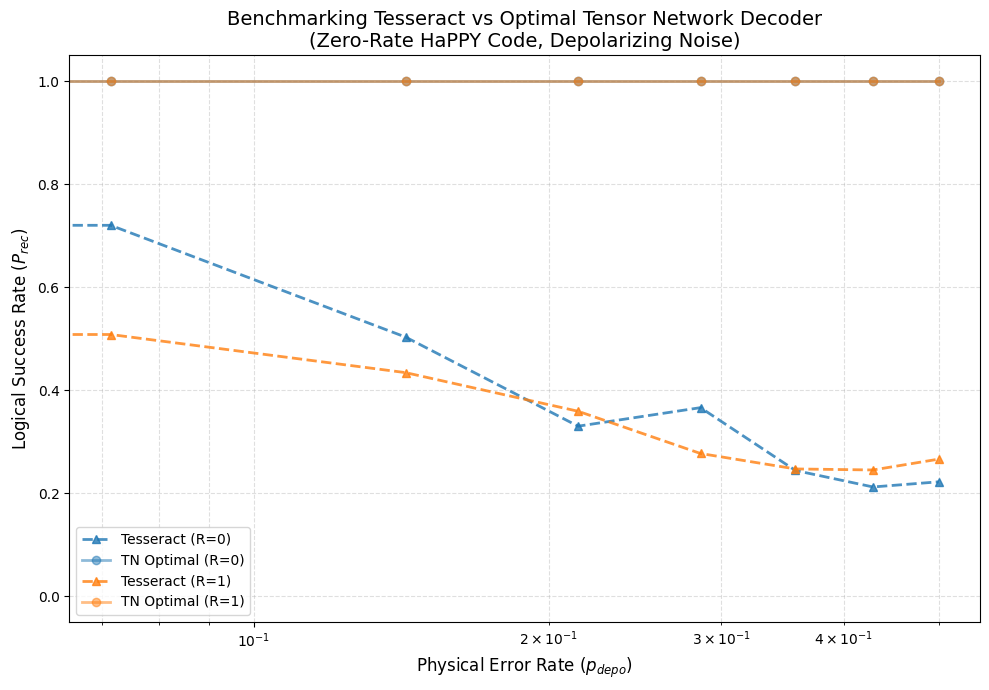

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import os
from multiprocessing import freeze_support

# --- HQEC Imports ---
# We use Zero-Rate HaPPY because that is what you simulated with Tesseract
from LEGO_HQEC.OperatorPush.Presets.HaPPY_code import setup_zero_rate_happy
from LEGO_HQEC.OperatorPush.Presets.Holographic_Steane_code import setup_heptagon_zero_rate_steane
from LEGO_HQEC.QuDec.TN_decoder import tn_quantum_error_correction_decoder_multiprocess

def main():
    print("="*60)
    print(" REPRODUCING FIG 6(b): TESSERACT VS TN BENCHMARK (LOG SCALE)")
    print("="*60)

    # 1. Define the P-values exactly as you simulated them
    # Range: 1e-5 to 0.5 (Logarithmic spacing as requested)
    p_values = np.linspace(0,0.5,8)
    print(f"[*] Analyzing p values: {p_values}")

    # 2. Define Radii to plot (Paper typically uses 0, 1, 2)
    radii = [0, 1]
    
    # 3. Setup Plotting
    plt.figure(figsize=(10, 7))
    colors = ['tab:blue', 'tab:orange', 'tab:green']
    markers_tess = ['^', '^', '^']
    markers_tn = ['o', 'o', 'o']

    # 4. Loop through Radii
    for i, R in enumerate(radii):
        print(f"\n--- Processing Radius R={R} ---")
        
        # --- A. Load Tesseract Data ---
        # User format: np.savetxt(filename, array_of_logical_error_rates)
        filename = f"zrsteane_tesseract_logical_error_rates_lin_R={R}.txt"
        
        if os.path.exists(filename):
            print(f"    [Tesseract] Loading {filename}...")
            try:
                # Load Logical Error Rate directly
                tess_err = np.loadtxt(filename)
                
                # Validation
                if tess_err.size != p_values.size:
                    print(f"    [Warning] Data size mismatch! Expected {p_values.size}, got {tess_err.size}")
                    # Truncate or pad if necessary to avoid crash, but warn user
                    min_len = min(tess_err.size, p_values.size)
                    tess_err = tess_err[:min_len]
                    p_val_plot = p_values[:min_len]
                else:
                    p_val_plot = p_values

                # Convert to Success Rate (P_rec = 1 - P_err)
                tess_succ = 1.0 - tess_err
                
                # Plot Tesseract Curve
                plt.plot(p_val_plot, tess_succ, 
                         label=f'Tesseract (R={R})',
                         color=colors[i], marker=markers_tess[i], linestyle='--', 
                         linewidth=2, alpha=0.8)
            except Exception as e:
                print(f"    [Error] Could not read file: {e}")
        else:
            print(f"    [Tesseract] File '{filename}' not found. Skipping.")

        # --- B. Run TN Decoder (Benchmark) ---
        print(f"    [TN Decoder] Running Maximum Likelihood Decoding...")
        
        # Setup Tensor Network
        tensor_list = setup_heptagon_zero_rate_steane(R=R)
        
        # Depolarizing Noise Params (rx=ry=rz = 1/3)
        rx, ry, rz = 1/3, 1/3, 1/3
        
        tn_succ = []
        # Run simulation for exactly the same p values (Log Scale)
        for p in p_values:
            # We use N=500 for the benchmark to be relatively fast 
            # Increase N=10000 for publication quality smoothness
            try:
                rate = tn_quantum_error_correction_decoder_multiprocess(
                    tensor_list=tensor_list,
                    p=p,
                    rx=rx, ry=ry, rz=rz,
                    N=500, 
                    n_process=4 # Adjust based on your cores
                )
                tn_succ.append(rate)
            except Exception as e:
                # Handling Singular Matrix Error at low p
                if "singular" in str(e).lower() or "invertible" in str(e).lower():
                    print(f"    [Info] TN singular at low p={p:.1e}. Assuming Success=1.0.")
                    tn_succ.append(1.0)
                else:
                    print(f"    [Error] TN failed at p={p}: {e}")
                    tn_succ.append(0.0)
        
        # Plot TN Curve (Solid Line)
        plt.plot(p_values, tn_succ, 
                 label=f'TN Optimal (R={R})',
                 color=colors[i], marker=markers_tn[i], linestyle='-', 
                 linewidth=2, alpha=0.5)

    # 5. Finalize Plot
    plt.title("Benchmarking Tesseract vs Optimal Tensor Network Decoder\n(Zero-Rate HaPPY Code, Depolarizing Noise)", fontsize=14)
    plt.xlabel("Physical Error Rate ($p_{depo}$)", fontsize=12)
    plt.ylabel("Logical Success Rate ($P_{rec}$)", fontsize=12)
    
    # Use Log Scale for X-axis as requested by the data distribution
    plt.xscale('log')
    
    plt.ylim(-0.05, 1.05)
    plt.grid(True, which='both', linestyle='--', alpha=0.4)
    plt.legend(loc='lower left', fontsize=10)
    
    plt.tight_layout()
    output_file = "fig6b_reproduction_tesseract_vs_tn_log.png"
    plt.savefig(output_file, dpi=300)
    print(f"\n[*] Plot saved to {output_file}")
    plt.show()

if __name__ == "__main__":
    freeze_support()
    main()